In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf

In [2]:
# Function that takes an image file as input and returns a (350x350x3) numpy array of pixel values
from PIL import Image

def image_to_array(image_path):
    try:
        img = Image.open(image_path)
        img_array = np.array(img)
        img_array = img_array / 255.0
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [4]:
import os

# pos_directory = '/Volumes/PHILIPS UFD/all_cropped/pos'
# neg_directory = '/Volumes/PHILIPS UFD/all_cropped/neg'

pos_directory = 'C:/Users/Jimmy Walraff/OneDrive/Documents/Ulg/Master 1/Data Science Project/Project/Volumes/PHILIPS UFD/all_cropped/pos'
neg_directory = 'C:/Users/Jimmy Walraff/OneDrive/Documents/Ulg/Master 1/Data Science Project/Project/Volumes/PHILIPS UFD/all_cropped/neg'

count = 0
count_2 = 0
count_4 = 0
for filename in log_progress(os.listdir(pos_directory), every = 1):
    if filename.endswith(".png"):
        image_path = os.path.join(pos_directory, filename)
        pixels = image_to_array(image_path)
        if pixels is not None and pixels.shape != (350, 350, 3):
            count += 1
            if pixels.shape[2] == 2:
                count_2 += 1
            elif pixels.shape[2] == 4:
                count_4 += 1
print(count, count_2, count_4)

156 137 19


In [5]:
count = 0
count_2 = 0
count_4 = 0
for filename in log_progress(os.listdir(neg_directory), every = 1):
    if filename.endswith(".png"):
        image_path = os.path.join(neg_directory, filename)
        pixels = image_to_array(image_path)
        if pixels is not None and pixels.shape != (350, 350, 3):
            count += 1
            if pixels.shape[2] == 2:
                count_2 += 1
            elif pixels.shape[2] == 4:
                count_4 += 1
print(count, count_2, count_4)

576 512 64


In [6]:
pos_image_data = []
neg_image_data = []

sample_size = 100 # to delete, we want full images

for filename in os.listdir(pos_directory):
    if len(pos_image_data) == sample_size:
        break
    if filename.endswith(".png"):
        image_path = os.path.join(pos_directory, filename)
        pixels = image_to_array(image_path)
        if pixels is not None and pixels.shape == (350, 350, 3):
            pos_image_data.append(pixels)
            
for filename in os.listdir(neg_directory):
    if len(neg_image_data) == sample_size:
        break
    if filename.endswith(".png"):
        image_path = os.path.join(neg_directory, filename)
        pixels = image_to_array(image_path)
        if pixels is not None and pixels.shape == (350, 350, 3):
            neg_image_data.append(pixels)

In [7]:
X = np.array(pos_image_data)
Xnot = np.array(neg_image_data)

print("X shape : ", X.shape)
print("XNOT shape : ", Xnot.shape)

X shape :  (100, 350, 350, 3)
XNOT shape :  (100, 350, 350, 3)


In [8]:
y = np.ones(sample_size)
ynot = np.zeros(sample_size)

print("y shape : ", y.shape)
print("yNOT shape : ", ynot.shape)

y shape :  (100,)
yNOT shape :  (100,)


In [9]:
Xtot = np.concatenate((X, Xnot), axis=0)
ytot = np.concatenate((y, ynot), axis=0)

print("Xtot shape : ", Xtot.shape)
print("ytot shape : ", ytot.shape)

Xtot shape :  (200, 350, 350, 3)
ytot shape :  (200,)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xtot, ytot, test_size=0.2, random_state=42)

print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (160, 350, 350, 3)
X_test shape :  (40, 350, 350, 3)
y_train shape :  (160,)
y_test shape :  (40,)


In [11]:
layers_size = 64
conv_size = 5
dense_size = 1
conv_layers = 3
dense_layer = 1

In [12]:
# check_point_path = 'Training/cp-{epoch:04d}.ckpt'

In [13]:
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=check_point_path, save_weights_only=True, verbose=1)

In [14]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(layers_size, conv_size, input_shape=(350, 350, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

for i in range(conv_layers-1):
    model.add(tf.keras.layers.Conv2D(layers_size, conv_size, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())

for i in range(dense_layer):
    model.add(tf.keras.layers.Dense(layers_size, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 350, 350, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 175, 175, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 175, 175, 64)      102464    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 87, 87, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 87, 87, 64)        102464    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 43, 43, 64)      

In [15]:
# Fitting = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks=[cp_callback]) # need to add callback
Fitting = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2) # need to add callback

model.save('Models/modelV0')

Epoch 1/10


4/4 [==============================] - 21s 5s/step - loss: 1.5279 - accuracy: 0.5625 - val_loss: 0.7488 - val_accuracy: 0.5312
Epoch 2/10
4/4 [==============================] - 19s 5s/step - loss: 0.7173 - accuracy: 0.5625 - val_loss: 0.7007 - val_accuracy: 0.4688
Epoch 3/10
4/4 [==============================] - 19s 5s/step - loss: 0.7192 - accuracy: 0.4375 - val_loss: 0.6927 - val_accuracy: 0.5312
Epoch 4/10
4/4 [==============================] - 19s 5s/step - loss: 0.6909 - accuracy: 0.5078 - val_loss: 0.6928 - val_accuracy: 0.4688
Epoch 5/10
4/4 [==============================] - 19s 5s/step - loss: 0.6941 - accuracy: 0.4844 - val_loss: 0.6929 - val_accuracy: 0.4688
Epoch 6/10
4/4 [==============================] - 19s 5s/step - loss: 0.6932 - accuracy: 0.5078 - val_loss: 0.6931 - val_accuracy: 0.4688
Epoch 7/10
4/4 [==============================] - 19s 5s/step - loss: 0.6921 - accuracy: 0.4766 - val_loss: 0.6925 - val_accuracy: 0.5312
Epoch 8/10
4/4 [================

INFO:tensorflow:Assets written to: Models/modelV0\assets


In [16]:
from sklearn.metrics import accuracy_score
y_predictions = model.predict(X_test)
y_pred = np.where(y_predictions>0.5,1,0)
acc = accuracy_score(y_pred,y_test)
print(acc)

2/2 [==============================] - 2s 331ms/step
0.5


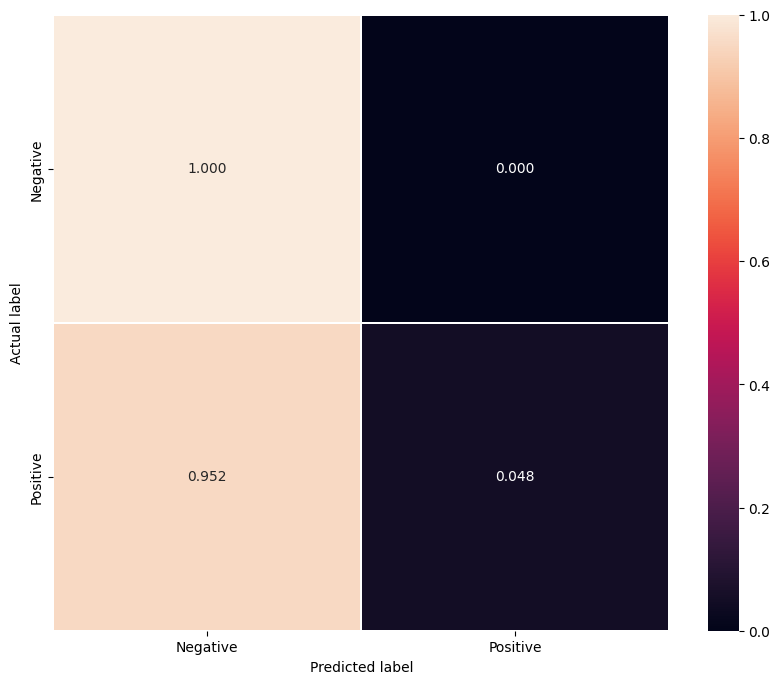

In [17]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

groups = ['Negative', 'Positive']

cm = metrics.confusion_matrix(y_test.reshape(y_pred.shape[0]), y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,8))

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.2, square = True, xticklabels=groups, yticklabels=groups)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig("ConfusionMatrix.pdf")

plt.show()